## RL for Predictive Maintenance
### REINFORCE with Attention Mechanism
- V.2.0: 08-Nov-2025
- 

In [1]:
import warnings
import logging
import os
import numpy as np

# Global Python warnings
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

#### Imports

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import os
from typing import Tuple, Dict, Any, List

# --------------------
# Global configuration
# --------------------
SENSOR_DATA = 'PROC_9'
DATA_FILE = f'data\{SENSOR_DATA}.csv'   # default data file path
R1_CONTINUE = 1.0                       # base reward for continuing / used-life multiplier
R2_REPLACE = 5.0                        # penalty weight for unused life when replacing early
R3_VIOLATION = 50.0                     # large penalty for crossing WEAR_THRESHOLD (bad)
AMR = 5e-2                                # Advantage Mixing Ratio for REINFORCE with AM

WEAR_THRESHOLD = 290                    # wear threshold (units must match wear calculation)
EPISODES = 1500                         # suggested training episodes'
LEARNING_RATE = 1e-2                    # Learning rate for optimizers
GAMMA = 0.99                            # Discount factor for future rewards
SMOOTH_WINDOW = 50                      # Window size for moving average smoothing on plots
SAVE_MODEL = True                       # Save model
REINFORCE_MODEL = f'models/{SENSOR_DATA}_REINFORCE_Model_{EPISODES}.h5'
REINFORCE_AM_MODEL = f'models/{SENSOR_DATA}_REINFORCE_AM_Model_{EPISODES}.h5'
PPO_MODEL = f'models/{SENSOR_DATA}_PPO_Model_{EPISODES}.zip'  # PPO uses .zip extension by default

#### Standard environment 


In [3]:

# Actions
CONTINUE = 0
REPLACE_TOOL = 1

class MT_Env(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, data_file=DATA_FILE, wear_threshold=WEAR_THRESHOLD, r1=R1_CONTINUE, r2=R2_REPLACE, r3=R3_VIOLATION):
        super().__init__()
        self.data_file = data_file
        self.df = pd.read_csv(self.data_file)
        required_cols = [
            "Time", "Vib_Spindle", "Vib_Table", "Sound_Spindle", "Sound_table",
            "X_Load_Cell", "Y_Load_Cell", "Z_Load_Cell", "Current", "tool_wear"
        ]
        for c in required_cols:
            if c not in self.df.columns:
                raise ValueError(f"Missing required column in data file: {c}")
        self.tool_wear_series = pd.to_numeric(self.df["tool_wear"], errors="coerce").to_numpy()
        if np.any(np.isnan(self.tool_wear_series)):
            raise ValueError("Non-numeric or missing values found in 'tool_wear' column.")


        # $$$ Compatibility with Attention Env $$$
        self.features = ['Vib_Spindle', 'Vib_Table', 'Sound_Spindle', 'Sound_table', 'X_Load_Cell', 'Y_Load_Cell', 'Z_Load_Cell', 'Current']

        # ensure features exist
        missing = [f for f in self.features if f not in self.df.columns]
        if missing:
            raise ValueError(f"Missing features in dataset: {missing}")

        # compute per-feature normalization stats
        vals_df = self.df[self.features].astype(np.float32)
        self.feature_means = vals_df.mean(axis=0).to_numpy(dtype=np.float32)
        self.feature_stds = vals_df.std(axis=0).replace(0, 1.0).to_numpy(dtype=np.float32)
        attn = np.ones(len(self.features), dtype=np.float32)
        self.attention_weights = attn.astype(np.float32)
        # $$$ Compatibility with Attention Env $$$



        self.wear_threshold = float(wear_threshold)
        self.r1 = float(r1)
        self.r2 = float(r2)
        self.r3 = float(r3)

        obs_low = np.full((8,), -np.finfo(np.float32).max, dtype=np.float32)
        obs_high = np.full((8,), np.finfo(np.float32).max, dtype=np.float32)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)
        self.action_space = spaces.Discrete(2)

        self.current_idx = 0
        self.done = False
        self._last_terminal_margin = np.nan

    def _get_observation(self, idx):
        row = self.df.iloc[idx]
        sensors = np.array([
            row["Vib_Spindle"], row["Vib_Table"], row["Sound_Spindle"], row["Sound_table"],
            row["X_Load_Cell"], row["Y_Load_Cell"], row["Z_Load_Cell"], row["Current"]
        ], dtype=np.float32)
        return sensors

    def _get_tool_wear(self, idx):
        return float(self.tool_wear_series[idx])

    def _compute_margin(self, idx):
        wear = self._get_tool_wear(idx)
        return float(self.wear_threshold - wear)

    def step(self, action):
        if self.done:
            obs = self._get_observation(min(self.current_idx, len(self.df)-1))
            info = {
                'violation': bool(self._get_tool_wear(self.current_idx) >= self.wear_threshold),
                'replacement': False,
                'margin': float(self._last_terminal_margin) if not np.isnan(self._last_terminal_margin) else float(self.wear_threshold - self._get_tool_wear(self.current_idx))
            }
            return obs, 0.0, True, False, info

        if action not in (CONTINUE, REPLACE_TOOL):
            raise ValueError("Invalid action.")

        tool_wear = self._get_tool_wear(self.current_idx)
        reward = 0.0
        info = {'violation': False, 'replacement': False, 'margin': np.nan}

        if action == CONTINUE:
            if tool_wear >= self.wear_threshold:
                reward = -self.r3
                self.done = True
                info['violation'] = True
                info['replacement'] = False
                info['margin'] = self._compute_margin(self.current_idx)
                self._last_terminal_margin = info['margin']
                obs = self._get_observation(self.current_idx)
                return obs, float(reward), True, False, info
            else:
                reward = self.r1
                if self.current_idx + 1 < len(self.df):
                    self.current_idx += 1
                    obs = self._get_observation(self.current_idx)
                    return obs, float(reward), False, False, info
                else:
                    self.done = True
                    info['violation'] = False
                    info['replacement'] = False
                    info['margin'] = self._compute_margin(self.current_idx)
                    self._last_terminal_margin = info['margin']
                    obs = self._get_observation(self.current_idx)
                    return obs, float(reward), True, False, info

        else:  # REPLACE_TOOL
            info['replacement'] = True
            info['margin'] = self._compute_margin(self.current_idx)
            if tool_wear >= self.wear_threshold:
                reward = -self.r3
                info['violation'] = True
            else:
                used_fraction = np.clip(tool_wear / self.wear_threshold, 0.0, 1.0)
                unused_fraction = 1.0 - used_fraction
                reward = self.r1 * used_fraction - self.r2 * unused_fraction
                info['violation'] = False
            self.done = True
            self._last_terminal_margin = info['margin']
            obs = self._get_observation(self.current_idx)
            return obs, float(reward), True, False, info

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_idx = 0
        self.done = False
        self._last_terminal_margin = np.nan
        obs = self._get_observation(self.current_idx)
        info = {'violation': False, 'replacement': False, 'margin': np.nan}
        return obs, info

    def render(self, mode="human"):
        if self.done:
            print(f"[MT-Environment V2 02-Nov-2025] done. idx={self.current_idx}, margin={self._last_terminal_margin}")
        else:
            wear_val = self._get_tool_wear(self.current_idx)
            print(f"[MT-Environment V2 02-Nov-2025] idx={self.current_idx}, tool_wear={wear_val:.3f}")

    def close(self):
        pass


#### Test environment

In [4]:
# env = MT_Env(data_file=DATA_FILE, wear_threshold=290, r1=1.0, r2=1.0, r3=50.0)
# obs, info = env.reset()
# done = False

# for i in range(10):
#     action = CONTINUE  # placeholder policy
#     obs, reward, done, truncated, info = env.step(action)
#     env.render()

#### Plotting

In [5]:
# --- Task 4: Plotting the Comparison ---

def smooth(data: List[float], window_size: int) -> np.ndarray:
    """
    Applies a simple moving average to a list of data.
    Handles NaNs by ignoring them in the window calculation.
    """
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().to_numpy()

def plot_metrics(reinforce_metrics: Dict, ppo_metrics: Dict, window: int, mode: str = "COMBINED", data_file: str = SENSOR_DATA):
    """
    Generates performance metric plots either combined or separate.
    
    Args:
        reinforce_metrics (Dict): Dictionary containing REINFORCE metrics
        ppo_metrics (Dict): Dictionary containing PPO metrics
        window (int): Window size for smoothing the curves
        mode (str): Either "COMBINED" or "SEPARATE" for plotting style
    """
    W, H = 16, 6
    FONTSIZE_SUPER = 18
    FONTSIZE_TITLE = 12
    FONTSIZE_LABEL = 10
    FONTSIZE_TICK = 9
    BACKGROUND_COLOR = '#f8f8f8'  # Lighter grey background
    
    def setup_subplot(ax, title, xlabel, ylabel):
        """Helper function to set up common subplot properties"""
        ax.set_title(title, fontsize=FONTSIZE_TITLE)
        ax.set_xlabel(xlabel, fontsize=FONTSIZE_LABEL)
        ax.set_ylabel(ylabel, fontsize=FONTSIZE_LABEL)
        ax.tick_params(labelsize=FONTSIZE_TICK)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_facecolor(BACKGROUND_COLOR)
    
    # Get data ranges for consistent y-axis limits
    def get_data_ranges(metrics_config):
        ranges = {}
        for config in metrics_config:
            key = config['data']
            if key == 'margins':
                r_data = pd.Series(reinforce_metrics[key]).rolling(window, min_periods=1).mean()
                p_data = pd.Series(ppo_metrics[key]).rolling(window, min_periods=1).mean()
            else:
                r_data = smooth(reinforce_metrics[key], window)
                p_data = smooth(ppo_metrics[key], window)
            
            all_data = np.concatenate([r_data, p_data])
            ranges[key] = (np.nanmin(all_data), np.nanmax(all_data))
        return ranges
        
    if mode.upper() == "COMBINED":
        # Create single figure with both algorithms
        fig, axs = plt.subplots(2, 2, figsize=(W, H))
        fig.suptitle(f'REINFORCE vs. PPO Performance [Data: {data_file}]', fontsize=FONTSIZE_SUPER)
        
        # Plot all metrics with both algorithms
        metrics_config = [
            {'data': 'rewards', 'title': 'Learning Curve (Smoothed Average Reward)', 
             'ylabel': 'Average Reward'},
            {'data': 'replacements', 'title': 'Replacements per episode (Smoothed)', 
             'ylabel': 'Replacement Rate'},
            {'data': 'violations', 'title': 'Threshold Violations per episode (Smoothed)', 
             'ylabel': 'Violation Rate'},
            {'data': 'margins', 'title': 'Wear Margin Before Replacement (Smoothed)', 
             'ylabel': 'Wear Margin'}
        ]
        
        for idx, config in enumerate(metrics_config):
            ax = axs[idx // 2, idx % 2]
            if config['data'] == 'margins':
                r_data = pd.Series(reinforce_metrics[config['data']]).rolling(window, min_periods=1).mean()
                p_data = pd.Series(ppo_metrics[config['data']]).rolling(window, min_periods=1).mean()
            else:
                r_data = smooth(reinforce_metrics[config['data']], window)
                p_data = smooth(ppo_metrics[config['data']], window)
                
            ax.plot(r_data, label='REINFORCE', alpha=0.6)
            ax.plot(p_data, label='PPO', alpha=0.6)
            setup_subplot(ax, config['title'], 'Episode', config['ylabel'])
            ax.legend()
        
    else:  # SEPARATE mode
        # First calculate data ranges for consistent scaling
        metrics_config = [
            {'data': 'rewards', 'color': 'blue', 'title': 'Learning Curve (Smoothed Average Reward)', 
             'ylabel': 'Average Reward'},
            {'data': 'replacements', 'color': 'green', 'title': 'Replacements per episode (Smoothed)', 
             'ylabel': 'Replacement Rate'},
            {'data': 'violations', 'color': 'red', 'title': 'Threshold Violations per episode (Smoothed)', 
             'ylabel': 'Violation Rate'},
            {'data': 'margins', 'color': 'purple', 'title': 'Wear Margin Before Replacement (Smoothed)', 
             'ylabel': 'Wear Margin'}
        ]
        data_ranges = get_data_ranges(metrics_config)
        
        # Create separate figures for each algorithm
        for algo, metrics in [("REINFORCE", reinforce_metrics), ("PPO", ppo_metrics)]:
            fig, axs = plt.subplots(2, 2, figsize=(W, H))
            fig.patch.set_facecolor(BACKGROUND_COLOR)  # Set figure background
            fig.suptitle(f'{algo} Performance Metrics for Predictive Maintenance [Data: {data_file}]', fontsize=FONTSIZE_SUPER)
            
            for idx, config in enumerate(metrics_config):
                ax = axs[idx // 2, idx % 2]
                if config['data'] == 'margins':
                    data = pd.Series(metrics[config['data']]).rolling(window, min_periods=1).mean()
                else:
                    data = smooth(metrics[config['data']], window)
                    
                ax.plot(data, color=config['color'], alpha=0.6)
                setup_subplot(ax, config['title'], 'Episode', config['ylabel'])
                
                # Set consistent y-axis limits
                ymin, ymax = data_ranges[config['data']]
                padding = (ymax - ymin) * 0.1  # Add 10% padding
                # ax.set_ylim(ymin - padding, ymax + padding)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def plot_metrics_RF_AM (reinforce_metrics: Dict, attention_metrics: Dict, window: int, mode: str ="COMBINED", data_file: str = SENSOR_DATA):
    """
    Generates performance metric plots either combined or separate.

    Args:
    reinforce_metrics (Dict): Dictionary containing REINFORCE metrics
    attention_metrics (Dict): Dictionary containing attention_metrics
    window (int): Window size for smoothing the curves
    mode (str): Either "COMBINED" or "SEPARATE" for plotting style
    """
    W, H = 16, 6
    FONTSIZE_SUPER = 18
    FONTSIZE_TITLE = 12
    FONTSIZE_LABEL = 10
    FONTSIZE_TICK = 9
    BACKGROUND_COLOR = '#f8f8f8' # Lighter grey background

    def setup_subplot(ax, title, xlabel, ylabel):
        """Helper function to set up common subplot properties"""
        ax.set_title(title, fontsize=FONTSIZE_TITLE)
        ax.set_xlabel(xlabel, fontsize=FONTSIZE_LABEL)
        ax.set_ylabel(ylabel, fontsize=FONTSIZE_LABEL)
        ax.tick_params(labelsize=FONTSIZE_TICK)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_facecolor(BACKGROUND_COLOR)

    # Get data ranges for consistent y-axis limits
    def get_data_ranges(metrics_config):
        ranges = {}
        for config in metrics_config:
            key = config['data']
            if key == 'margins':
                r_data = pd.Series(reinforce_metrics[key]).rolling(window, min_periods=1).mean()
                p_data = pd.Series(attention_metrics[key]).rolling(window, min_periods=1).mean()
            else:
                r_data = smooth(reinforce_metrics[key], window)
                p_data = smooth(attention_metrics[key], window)

            all_data = np.concatenate([r_data, p_data])
            ranges[key]= (np.nanmin(all_data), np.nanmax(all_data))
        return ranges

    # Create single figure with both algorithms
    fig, axs = plt.subplots(2, 2, figsize=(W, H))
    fig.suptitle(f'REINFORCE performance - without and with attention [Data: {data_file}]', fontsize=FONTSIZE_SUPER)

    # Plot all metrics with both algorithms
    metrics_config = [
        {'data': 'rewards', 'title': 'Learning Curve (Smoothed Average Reward)',
            'ylabel': 'Average Reward'},
        {'data': 'replacements', 'title': 'Replacements per episode (Smoothed)',
            'ylabel': 'Replacement Rate'},
        {'data': 'violations', 'title': 'Threshold Violations per episode (Smoothed)',
            'ylabel': 'Violation Rate'},
        {'data': 'margins', 'title': 'Wear Margin Before Replacement (Smoothed)',
            'ylabel': 'Wear Margin'}
    ]

    for idx, config in enumerate(metrics_config):
        ax = axs[idx // 2, idx % 2]
        if config['data'] == 'margins':
            r_data = pd.Series(reinforce_metrics[config['data']]).rolling(window, min_periods=1).mean()
            p_data = pd.Series(attention_metrics[config['data']]).rolling(window, min_periods=1).mean()
        else:
            r_data = smooth(reinforce_metrics[config['data']], window)
            p_data = smooth(attention_metrics[config['data']], window)

        ax.plot(r_data, label='Raw sensor', alpha=0.6, color='tab:blue')
        ax.plot(p_data, label='+ Attention', alpha=0.6, color='tab:red')
        setup_subplot(ax, config['title'], 'Episode', config['ylabel'])
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

#### REINFORCE algo

In [6]:
# --- Task 2: REINFORCE Algorithm Implementation ---
# A custom implementation of the REINFORCE algorithm with a structure
# similar to Stable Baselines3 for easy comparison.
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.net(x)

class REINFORCE:
    """
    A custom REINFORCE agent.
    """
    def __init__(self, policy, env, learning_rate=0.001, gamma=0.99, model_file=None):
        self.env = env
        self.policy = policy
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.model_name = "REINFORCE"
        self.model_file = model_file

    def predict(self, obs: np.ndarray) -> int:
        """
        Selects an action based on the current observation.
        Uses the same action selection logic as training for consistency.
        """
        with torch.no_grad():  # Important to disable gradients for prediction
            state_tensor = torch.FloatTensor(obs).unsqueeze(0)
            probs = self.policy(state_tensor)
            dist = Categorical(probs)
            action = dist.sample()  # Sample action like in training
            return action.item()        

    def learn(self, total_episodes: int) -> Dict[str, List]:
        """
        Trains the agent for a given number of episodes.
        """
        print(f"--- Training {self.model_name} ---")
        # Metrics collectors
        all_rewards = []
        all_violations = []
        all_replacements = []
        all_margins = []

        for episode in range(total_episodes):
            log_probs = []
            rewards = []
            obs, _ = self.env.reset()
            done = False
            
            episode_info = {'violation': 0, 'replacement': 0, 'margin': np.nan}

            while not done:
                state_tensor = torch.FloatTensor(obs).unsqueeze(0)
                probs = self.policy(state_tensor)
                dist = Categorical(probs)
                action = dist.sample()

                log_prob = dist.log_prob(action)
                log_probs.append(log_prob)

                obs, reward, terminated, truncated, info = self.env.step(action.item())
                rewards.append(reward)
                done = terminated or truncated

                if info.get('violation'): episode_info['violation'] = 1
                if info.get('replacement'): episode_info['replacement'] = 1
                if not np.isnan(info.get('margin')): episode_info['margin'] = info.get('margin')
            
            # Collect metrics for this episode
            all_rewards.append(sum(rewards))
            all_violations.append(episode_info['violation'])
            all_replacements.append(episode_info['replacement'])
            all_margins.append(episode_info['margin'])

            # Calculate discounted returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + self.gamma * G
                returns.insert(0, G)
            returns = torch.tensor(returns, dtype=torch.float32)
            
            # Normalize returns for stability, but only if there's more than one step
            # to avoid std() of a single item becoming NaN.
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-9)

            # Calculate policy loss and update weights
            policy_loss = []
            for log_prob, G in zip(log_probs, returns):
                policy_loss.append(-log_prob * G)
            
            self.optimizer.zero_grad()
            policy_loss = torch.cat(policy_loss).sum()
            policy_loss.backward()
            self.optimizer.step()

            if (episode + 1) % 50 == 0:
                print(f"Episode {episode + 1}/{total_episodes}, Total Reward: {sum(rewards):.2f}")
        
        print("--- Training Complete ---")
        
        # Save model if file path was provided
        if self.model_file is not None:
            try:
                # Create directory if it doesn't exist
                os.makedirs(os.path.dirname(self.model_file), exist_ok=True)
                # Save the model
                torch.save({
                    'policy_state_dict': self.policy.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'input_dim': self.policy.net[0].in_features,
                    'output_dim': self.policy.net[-2].out_features
                }, self.model_file)
                print(f"Model saved successfully to: {self.model_file}")
            except Exception as e:
                print(f"Error saving model: {str(e)}")

        return {
            "rewards": all_rewards,
            "violations": all_violations,
            "replacements": all_replacements,
            "margins": all_margins
        }


#### Training REINFORCE

In [7]:
# Create the environment
try:
    # Create a base environment for the custom REINFORCE agent
    reinforce_env = MT_Env(
        data_file=DATA_FILE,
        wear_threshold=WEAR_THRESHOLD,
        r1=R1_CONTINUE,
        r2=R2_REPLACE,
        r3=R3_VIOLATION
    )
    # It's good practice to check if the custom environment is valid
    check_env(reinforce_env)
    print("Environment created and checked successfully.")

    # Create a separate, monitored environment for the Stable Baselines3 PPO agent
    ppo_env = Monitor(MT_Env(
        data_file=DATA_FILE,
        wear_threshold=WEAR_THRESHOLD,
        r1=R1_CONTINUE,
        r2=R2_REPLACE,
        r3=R3_VIOLATION
    ))

except FileNotFoundError as e:
    print(e)
    # Exit if the data file is not found
    exit()

Environment created and checked successfully.


In [8]:
# Train REINFORCE agent
print('\n\n Training REINFORCE agent...')
reinforce_policy = PolicyNetwork(reinforce_env.observation_space.shape[0], reinforce_env.action_space.n)
reinforce_agent = REINFORCE(reinforce_policy, reinforce_env, learning_rate=LEARNING_RATE, gamma=GAMMA)
reinforce_metrics = reinforce_agent.learn(total_episodes=EPISODES)
print('\n -- REINFORCE agent training complete.')

# Save REINFORCE model
if SAVE_MODEL:
    try:
        torch.save({
            'policy_state_dict': reinforce_agent.policy.state_dict(),
            'optimizer_state_dict': reinforce_agent.optimizer.state_dict(),
            'input_dim': reinforce_agent.policy.net[0].in_features,
            'output_dim': reinforce_agent.policy.net[-2].out_features
        }, REINFORCE_MODEL)
        print(f"Model saved successfully to: {REINFORCE_MODEL}")
    except Exception as e:
        print(f"Error saving model: {str(e)}")



 Training REINFORCE agent...
--- Training REINFORCE ---
Episode 50/1500, Total Reward: 312.00
Episode 100/1500, Total Reward: 312.00
Episode 150/1500, Total Reward: 312.00
Episode 200/1500, Total Reward: 312.00
Episode 250/1500, Total Reward: 312.00
Episode 300/1500, Total Reward: 312.00
Episode 350/1500, Total Reward: 312.00
Episode 400/1500, Total Reward: 312.00
Episode 450/1500, Total Reward: 312.00
Episode 500/1500, Total Reward: 312.00
Episode 550/1500, Total Reward: 312.00
Episode 600/1500, Total Reward: 312.00
Episode 650/1500, Total Reward: 312.00
Episode 700/1500, Total Reward: 312.00
Episode 750/1500, Total Reward: 312.00
Episode 800/1500, Total Reward: 312.00
Episode 850/1500, Total Reward: 312.00
Episode 900/1500, Total Reward: 312.00
Episode 950/1500, Total Reward: 312.00
Episode 1000/1500, Total Reward: 312.00
Episode 1050/1500, Total Reward: 312.00
Episode 1100/1500, Total Reward: 312.00
Episode 1150/1500, Total Reward: 312.00
Episode 1200/1500, Total Reward: 312.00
Ep

#### PPO MetricsCallback

In [9]:
# --- Task 3: Comparison with Stable Baselines3 PPO ---
# We use a callback to collect metrics during PPO training to ensure a
# fair, episode-by-episode comparison with our REINFORCE agent.

class MetricsCallback(BaseCallback):
    """
    A custom callback for saving metrics at the end of each episode.
    """
    def __init__(self, verbose=0):
        super(MetricsCallback, self).__init__(verbose)
        self.rewards = []
        self.violations = []
        self.replacements = []
        self.margins = []

    def _on_step(self) -> bool:
        # Check if an episode has ended
        if self.locals['dones'][0]:
            # The Monitor wrapper ensures the info dict has 'episode' stats
            info = self.locals['infos'][0]
            self.rewards.append(info['episode']['r'])
            self.violations.append(1 if info.get('violation') else 0)
            self.replacements.append(1 if info.get('replacement') else 0)
            self.margins.append(info.get('margin', np.nan))
        return True

def train_ppo(env: gym.Env, total_episodes: int, model_file: str = None) -> Dict[str, List]:
    """
    Trains a PPO agent and collects metrics using a callback.
    Optionally saves the trained model if model_file is provided.

    Args:
        env: The training environment
        total_episodes: Number of episodes to train
        model_file: Optional path to save the trained model
    """
    print("--- Training PPO ---")
    callback = MetricsCallback()
    
    # Since we train by episode, we set a very high number of timesteps
    # and rely on the custom loop to stop at the right number of episodes.
    total_timesteps = 1_000_000 

    model = PPO("MlpPolicy", env, verbose=0, learning_rate=LEARNING_RATE, gamma=GAMMA)
    
    # We can now use the standard model.learn() with our callback,
    # but we need a way to stop after N episodes. A custom loop is still clearer.
    obs, _ = env.reset()
    ep_count = 0
    while ep_count < total_episodes:
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        
        # Manually trigger the callback's on_step method
        callback.model = model
        callback.locals = {'dones': [terminated or truncated], 'infos': [info]}
        callback._on_step()
        
        if terminated or truncated:
            ep_count += 1
            if (ep_count) % 100 == 0:
                print(f"Episode {ep_count}/{total_episodes}")
            obs, _ = env.reset()

    print("--- Training Complete ---")

    # Save model if file path was provided
    if model_file is not None:
        try:
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(model_file), exist_ok=True)
            # Save the model using SB3's built-in save method
            model.save(model_file)
            print(f"PPO model saved successfully to: {model_file}")
        except Exception as e:
            print(f"Error saving PPO model: {str(e)}")

    return {
        "rewards": callback.rewards,
        "violations": callback.violations,
        "replacements": callback.replacements,
        "margins": callback.margins
    }

In [10]:
print('\n\n Training PPO agent...')
ppo_metrics = train_ppo(ppo_env, total_episodes=EPISODES, model_file=PPO_MODEL)
print('\n -- PPO agent training complete.')



 Training PPO agent...
--- Training PPO ---
Episode 100/1500
Episode 200/1500
Episode 300/1500
Episode 400/1500
Episode 500/1500
Episode 600/1500
Episode 700/1500
Episode 800/1500
Episode 900/1500
Episode 1000/1500
Episode 1100/1500
Episode 1200/1500
Episode 1300/1500
Episode 1400/1500
Episode 1500/1500
--- Training Complete ---
PPO model saved successfully to: models/PROC_10_PPO_Model_1500.zip

 -- PPO agent training complete.


#### Average metrics for comparison

In [11]:
def average_metrics(metrics_a: Dict[str, List], metrics_b: Dict[str, List], 
                   name_a: str = None, name_b: str = None, data_file: str = SENSOR_DATA,
                   leave_first_N: int = 0) -> Dict[str, Dict[str, float]]:
    """
    Compute average metrics for two different algorithms/approaches,
    optionally skipping the first `leave_first_N` entries when computing averages.

    Args:
        metrics_a (Dict): Dictionary containing metrics for first approach
        metrics_b (Dict): Dictionary containing metrics for second approach
        name_a (str): Name of first approach (defaults to variable name in caller)
        name_b (str): Name of second approach (defaults to variable name in caller)
        data_file (str): Label for printing the data source
        leave_first_N (int): Number of initial entries to skip when averaging (default 0)

    Returns:
        Dict[str, Dict[str, float]]: Averaged metrics dictionary for both approaches.
    """
    # sanitize leave_first_N
    try:
        N = int(leave_first_N)
    except Exception:
        N = 0
    if N < 0:
        N = 0

    # attempt to infer names from caller if not provided
    if name_a is None or name_b is None:
        import inspect
        calling_frame = inspect.currentframe().f_back
        if name_a is None:
            name_a = next((n for n, v in calling_frame.f_locals.items() if v is metrics_a), "A")
        if name_b is None:
            name_b = next((n for n, v in calling_frame.f_locals.items() if v is metrics_b), "B")

    def safe_avg(seq):
        """Return average of seq after skipping first N items. Use nanmean for numeric safety."""
        try:
            arr = np.asarray(seq, dtype=float)
        except Exception:
            return float("nan")
        sliced = arr[N:]
        if sliced.size == 0:
            return float("nan")
        return float(np.nanmean(sliced))

    # keys expected in metrics dicts
    keys = ["rewards", "violations", "replacements", "margins"]

    metrics = {
        name_a: {
            'avg_reward': safe_avg(metrics_a.get('rewards', [])),
            'avg_violations': safe_avg(metrics_a.get('violations', [])),
            'avg_replacements': safe_avg(metrics_a.get('replacements', [])),
            'avg_margin': safe_avg(metrics_a.get('margins', []))
        },
        name_b: {
            'avg_reward': safe_avg(metrics_b.get('rewards', [])),
            'avg_violations': safe_avg(metrics_b.get('violations', [])),
            'avg_replacements': safe_avg(metrics_b.get('replacements', [])),
            'avg_margin': safe_avg(metrics_b.get('margins', []))
        }
    }

    # Print the metrics in a formatted way
    if N > 0:
        print(f'\nAverage Metrics Comparison [Data: {data_file}] (Steady state data, n={N})')
    else:
        print(f'\nAverage Metrics Comparison [Data: {data_file}]')
    print("-" * 64)
    print(f"{'Metric':<20} {name_a:>18} {name_b:>18}")
    print("-" * 64)

    metrics_names = {
        'avg_reward': 'Average Reward',
        'avg_violations': 'Violation Rate',
        'avg_replacements': 'Replacement Rate',
        'avg_margin': 'Average Margin'
    }

    for metric in metrics_names:
        a_val = metrics[name_a][metric]
        b_val = metrics[name_b][metric]
        a_str = f"{a_val:>18.4f}" if not np.isnan(a_val) else f"{'nan':>18}"
        b_str = f"{b_val:>18.4f}" if not np.isnan(b_val) else f"{'nan':>18}"
        print(f"{metrics_names[metric]:<20} {a_str} {b_str}")

    print("-" * 64)

    return metrics

#### REINFORCE vs PPO - Results

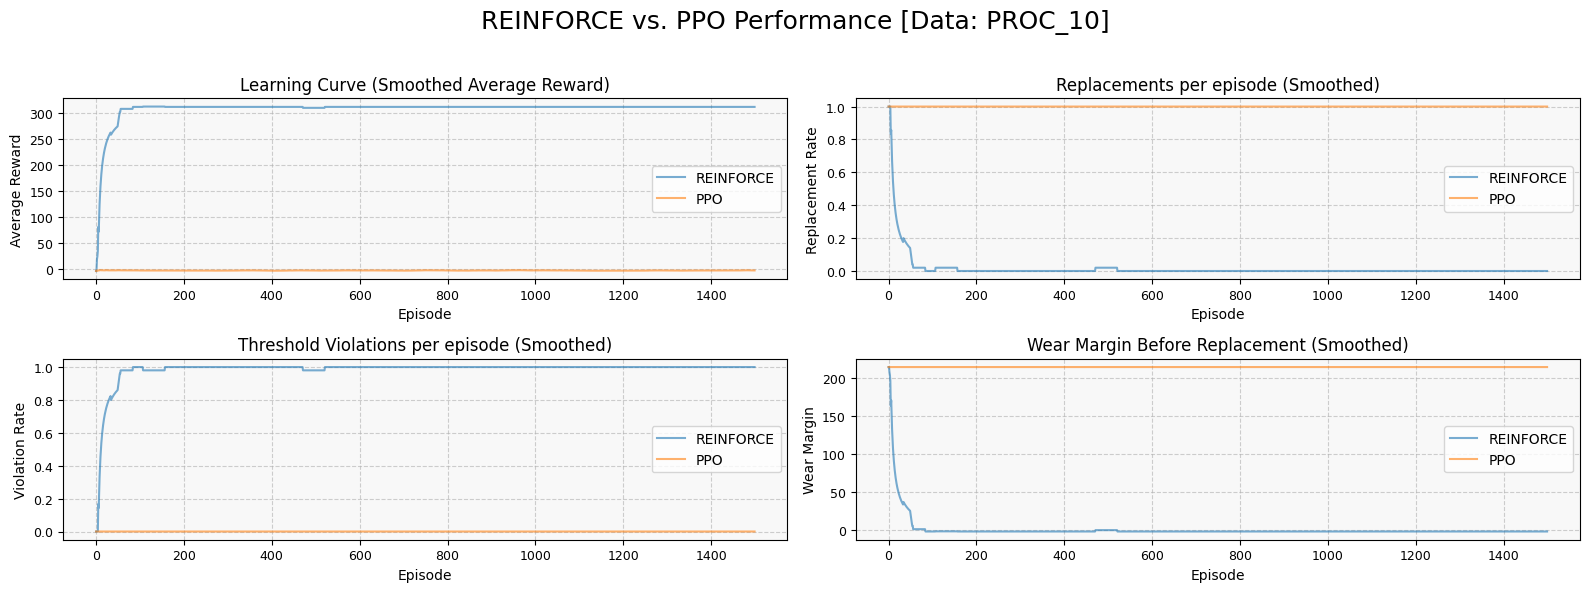


Average Metrics Comparison [Data: PROC_10]
----------------------------------------------------------------
Metric                        REINFORCE                PPO
----------------------------------------------------------------
Average Reward                 310.7155            -2.4494
Violation Rate                   0.9940             0.0000
Replacement Rate                 0.0060             1.0000
Average Margin                  -0.9982           214.0900
----------------------------------------------------------------


In [12]:
# For combined plots (both algorithms on same axes)
plot_metrics(reinforce_metrics, ppo_metrics, window=SMOOTH_WINDOW, mode="COMBINED")
m=average_metrics(reinforce_metrics, ppo_metrics, 'REINFORCE', 'PPO')

## Attention mechanism

#### Environment AM_Env

New corrected AM_Env

current_idx

In [13]:
class AM_Env(MT_Env):
    """
        Attention-augmented variant of MT_Env.

        - Uses the same sensor features as the dataset.
        Computes attention weights via KernelRidge(kernel='linear') fitted to features -> tool_wear,
        The primal coefficients are used to derive per-feature importances (absolute value, normalized).
        - Observation returned is the normalized feature vector multiplied elementwise by attention weights.
    """

    def _init_(self, data_file: str, wear_threshold: float, r1: float, r2: float, r3: float, kr_alpha: float = 1.0):
        super(AM_Env, self).__init__(data_file, wear_threshold, r1, r2, r3)

        # feature list (same as suggested earlier)
        self.features = ['Vib_Spindle', 'Vib_Table', 'Sound_Spindle', 'Sound_table', 'X_Load_Cell', 'Y_Load_Cell', 'Z_Load_Cell', 'Current']

        # ensure features exist
        missing = [f for f in self.features if f not in self.df.columns]
        if missing:
            raise ValueError(f"Missing features in dataset: {missing}")

        # compute per-feature normalization stats
        vals_df = self.df[self.features].astype(np.float32)
        self.feature_means = vals_df.mean(axis=0).to_numpy(dtype=np.float32)
        self.feature_stds = vals_df.std(axis=0).replace(0, 1.0).to_numpy(dtype=np.float32)

        # prepare training data for KernelRidge
        X = (vals_df - self.feature_means) / (self.feature_stds + 1e-9)
        x = x.to_numpy(dtype=np.float32)
        y = self.df['tool_wear'].to_numpy(dtype=np.float32)

        # fit KernelRidge (linear) to estimate feature importances
        try:
            from sklearn.kernel_ridge import KernelRidge
        except Exception as e:
            raise ImportError("scikit-learn is required for AM_Env. Install with `pip install scikit-learn") from e

        self._kr_model = KernelRidge(kernel='linear', alpha=kr_alpha)
        self._kr_model.fit(X, y)

        # compute primal coefficients from dual_coef_ and x_fit_
        # coef = x_fit _. T @ dual_coef_ (shape: n_features,)
        dual=np.asarray(self._kr_model.dual_coef_).reshape(-1, 1) # (n_train, 1)
        x_fit = np.asarray(self._kr_model.x_fit_) # (n_train, n_features)
        coef = (x_fit.T @ dual).ravel() # (n_features,)

        attn = np.abs(coef)
        if attn.sum() == 0:
            attn = np.ones_like(attn)
        attn = attn / (attn.sum() + 1e-12)
        self.attention_weights = attn.astype(np.float32)

        # observation space: attention-weighted feature vector
        self.observation_space = spaces.Box(low =- np.inf, high=np.inf, shape=(len(self.features),), dtype=np.float32)

    def get_observation(self) -> np.ndarray:
        """Return the attention-weighted, normalized feature vector for current step."""
        vals = self.df.loc[self.current_idx, self.features].to_numpy(dtype=np.float32)
        norm = (vals - self.feature_means) / (self.feature_stds + 1e-9)
        weighted = norm * self.attention_weights
        return weighted.astype(np.float32)
    
    def recompute_attention(self, window: int = None, kr_alpha: float = None):
        """
            Optionally recompute attention weights:
            - If window'is None -> use full dataset (same as init).
            - If window is int -> use last 'window rows up to current_step to compute local attention.
            - kr_alpha overrides regularization when refitting.
        """
        
        if window is None:
            df_slice = self.df[self.features]
        else:
            start = max(0, self.current_idx - window + 1)
            df_slice = self.df.loc[start:self.current_idx, self.features]
            if len(df_slice) < 2:
                df_slice = self.df[self.features] # fallback to full data if slice too small

        x = ((df_slice - self.feature_means) / (self.feature_stds + 1e-9)).to_numpy(dtype=np.float32)
        y = self.df.loc[df_slice.index, 'tool_wear'].to_numpy(dtype=np.float32)

        from sklearn.kernel_ridge import KernelRidge
        model = KernelRidge(kernel='linear', alpha=(kr_alpha if kr_alpha is not None else self._kr_model.alpha))
        model.fit(x, y)
        dual = np.asarray(model.dual_coef_).reshape(-1, 1)
        x_fit = np.asarray(model.x_fit )
        coef = (x_fit.T @ dual).ravel()
        attn = np.abs(coef)
        if attn.sum() == 0:
            attn = np.ones_like(attn)
        attn = attn / (attn.sum() + 1e-12)
        self.attention_weights = attn.astype(np.float32)

- Belwo one is the REAL Working AM_Env - the above was tried for Evaluation code compatibility

In [14]:
class WORKING_AM_Env(MT_Env):
    """
        Attention-augmented variant of MT_Env.

        - Uses the same sensor features as the dataset.
        Computes attention weights via KernelRidge(kernel='linear') fitted to features -> tool_wear,
        The primal coefficients are used to derive per-feature importances (absolute value, normalized).
        - Observation returned is the normalized feature vector multiplied elementwise by attention weights.
    """

    def _init_(self, data_file: str, wear_threshold: float, r1: float, r2: float, r3: float, kr_alpha: float = 1.0):
        super(AM_Env, self).__init__(data_file, wear_threshold, r1, r2, r3)

        # feature list (same as suggested earlier)
        self.features = ['Vib_Spindle', 'Vib_Table', 'Sound_Spindle', 'Sound_table', 'X_Load_Cell', 'Y_Load_Cell', 'Z_Load_Cell', 'Current']

        # ensure features exist
        missing = [f for f in self.features if f not in self.df.columns]
        if missing:
            raise ValueError(f"Missing features in dataset: {missing}")

        # compute per-feature normalization stats
        vals_df = self.df[self.features].astype(np.float32)
        self.feature_means = vals_df.mean(axis=0).to_numpy(dtype=np.float32)
        self.feature_stds = vals_df.std(axis=0).replace(0, 1.0).to_numpy(dtype=np.float32)

        # prepare training data for KernelRidge
        X = (vals_df - self.feature_means) / (self.feature_stds + 1e-9)
        x = x.to_numpy(dtype=np.float32)
        y = self.df['tool_wear'].to_numpy(dtype=np.float32)

        # fit KernelRidge (linear) to estimate feature importances
        try:
            from sklearn.kernel_ridge import KernelRidge
        except Exception as e:
            raise ImportError("scikit-learn is required for AM_Env. Install with `pip install scikit-learn") from e

        self._kr_model = KernelRidge(kernel='linear', alpha=kr_alpha)
        self._kr_model.fit(X, y)

        # compute primal coefficients from dual_coef_ and x_fit_
        # coef = x_fit _. T @ dual_coef_ (shape: n_features,)
        dual=np.asarray(self._kr_model.dual_coef_).reshape(-1, 1) # (n_train, 1)
        x_fit = np.asarray(self._kr_model.x_fit_) # (n_train, n_features)
        coef = (x_fit.T @ dual).ravel() # (n_features,)

        attn = np.abs(coef)
        if attn.sum() == 0:
            attn = np.ones_like(attn)
        attn = attn / (attn.sum() + 1e-12)
        self.attention_weights = attn.astype(np.float32)

        # observation space: attention-weighted feature vector
        self.observation_space = spaces.Box(low =- np.inf, high=np.inf, shape=(len(self.features),), dtype=np.float32)

    def get_observation(self) -> np.ndarray:
        """Return the attention-weighted, normalized feature vector for current step."""
        vals = self.df.loc[self.current_step, self.features].to_numpy(dtype=np.float32)
        norm = (vals - self.feature_means) / (self.feature_stds + 1e-9)
        weighted = norm * self.attention_weights
        return weighted.astype(np.float32)
    
    def recompute_attention(self, window: int = None, kr_alpha: float = None):
        """
            Optionally recompute attention weights:
            - If window'is None -> use full dataset (same as init).
            - If window is int -> use last 'window rows up to current_step to compute local attention.
            - kr_alpha overrides regularization when refitting.
        """
        
        if window is None:
            df_slice = self.df[self.features]
        else:
            start = max(0, self.current_step - window + 1)
            df_slice = self.df.loc[start:self.current_step, self.features]
            if len(df_slice) < 2:
                df_slice = self.df[self.features] # fallback to full data if slice too small

        x = ((df_slice - self.feature_means) / (self.feature_stds + 1e-9)).to_numpy(dtype=np.float32)
        y = self.df.loc[df_slice.index, 'tool_wear'].to_numpy(dtype=np.float32)

        from sklearn.kernel_ridge import KernelRidge
        model = KernelRidge(kernel='linear', alpha=(kr_alpha if kr_alpha is not None else self._kr_model.alpha))
        model.fit(x, y)
        dual = np.asarray(model.dual_coef_).reshape(-1, 1)
        x_fit = np.asarray(model.x_fit )
        coef = (x_fit.T @ dual).ravel()
        attn = np.abs(coef)
        if attn.sum() == 0:
            attn = np.ones_like(attn)
        attn = attn / (attn.sum() + 1e-12)
        self.attention_weights = attn.astype(np.float32)

In [15]:
# Create a base environment for the custom REINFORCE agent
reinforce_am_env = AM_Env(
    data_file=DATA_FILE,
    wear_threshold=WEAR_THRESHOLD,
    r1=R1_CONTINUE+AMR,
    r2=R2_REPLACE,
    r3=R3_VIOLATION)

check_env(reinforce_am_env)

### Train REINFORCE agent with Attention

In [16]:
# Train REINFORCE agent
print('\n\n Attention Based Environment: Training REINFORCE agent...')
reinforce_policy_am = PolicyNetwork(reinforce_am_env.observation_space.shape[0], reinforce_am_env.action_space.n)
reinforce_agent_am = REINFORCE(reinforce_policy_am, reinforce_am_env, learning_rate=LEARNING_RATE, gamma=GAMMA)
reinforce_metrics_am = reinforce_agent_am.learn(total_episodes=EPISODES)
print('\n -- Attention Based Environment: REINFORCE agent training complete.')

# Save attention-based REINFORCE model
if SAVE_MODEL:
    try:
        torch.save({
            'policy_state_dict': reinforce_agent_am.policy.state_dict(),
            'optimizer_state_dict': reinforce_agent_am.optimizer.state_dict(),
            'input_dim': reinforce_agent_am.policy.net[0].in_features,
            'output_dim': reinforce_agent_am.policy.net[-2].out_features
        }, REINFORCE_AM_MODEL)
        print(f"Attention Model saved successfully to: {REINFORCE_AM_MODEL}")
    except Exception as e:
        print(f"Error saving attention model: {str(e)}")



 Attention Based Environment: Training REINFORCE agent...
--- Training REINFORCE ---
Episode 50/1500, Total Reward: 330.10
Episode 100/1500, Total Reward: 330.10
Episode 150/1500, Total Reward: 330.10
Episode 200/1500, Total Reward: 330.10
Episode 250/1500, Total Reward: 330.10
Episode 300/1500, Total Reward: 330.10
Episode 350/1500, Total Reward: 330.10
Episode 400/1500, Total Reward: 330.10
Episode 450/1500, Total Reward: 330.10
Episode 500/1500, Total Reward: 330.10
Episode 550/1500, Total Reward: 330.10
Episode 600/1500, Total Reward: 330.10
Episode 650/1500, Total Reward: 330.10
Episode 700/1500, Total Reward: 330.10
Episode 750/1500, Total Reward: 330.10
Episode 800/1500, Total Reward: 330.10
Episode 850/1500, Total Reward: 330.10
Episode 900/1500, Total Reward: 330.10
Episode 950/1500, Total Reward: 330.10
Episode 1000/1500, Total Reward: 330.10
Episode 1050/1500, Total Reward: 330.10
Episode 1100/1500, Total Reward: 330.10
Episode 1150/1500, Total Reward: 330.10
Episode 1200/

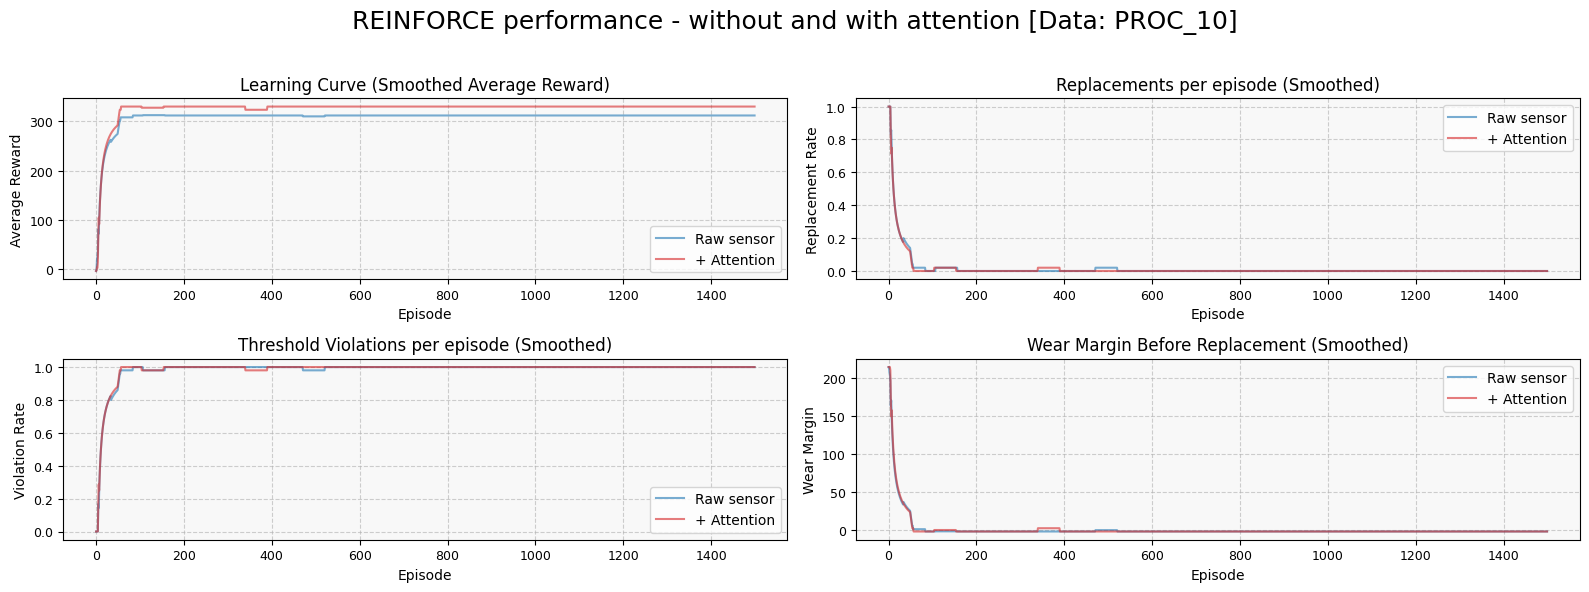


Average Metrics Comparison [Data: PROC_10]
----------------------------------------------------------------
Metric                           Normal     With Attention
----------------------------------------------------------------
Average Reward                 310.7155           328.5318
Violation Rate                   0.9940             0.9947
Replacement Rate                 0.0060             0.0053
Average Margin                  -0.9982            -0.9106
----------------------------------------------------------------


In [17]:
# For combined plots (both algorithms on same axes)
SMOOTH_WINDOW_AM = 50
plot_metrics_RF_AM(reinforce_metrics, reinforce_metrics_am, window=SMOOTH_WINDOW_AM, mode="COMBINED")
rf_am = average_metrics(reinforce_metrics, reinforce_metrics_am, 'Normal', 'With Attention')

## Evalution

In [18]:
def test_models_on_timeseries(
    test_file: str,
    wear_threshold: float = WEAR_THRESHOLD,
    ppo_model_file: str = PPO_MODEL,
    reinforce_model_file: str = REINFORCE_MODEL,
    reinforce_am_model_file: str = REINFORCE_AM_MODEL,
) -> "pd.DataFrame":
    """
    Run the entire test CSV as a time series through three saved models (PPO, REINFORCE, REINFORCE+AM)
    and produce a table with precision, recall, f1, accuracy and avg replacement margin per model.

    Assumes test CSV contains sensor columns used by MT_Env/AM_Env and a ground-truth ACTION column.
    """
    import pandas as pd
    import numpy as np
    import torch
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    from stable_baselines3 import PPO

    # load test file
    df = pd.read_csv(test_file)
    # find action column
    action_col = None
    for c in ("ACTION", "ACTION_CODE", "action", "action_code"):
        if c in df.columns:
            action_col = c
            break
    if action_col is None:
        raise ValueError("Test file must contain ACTION or ACTION_CODE column.")

    y_true = df[action_col].astype(int).to_numpy()
    n = len(df)

    # instantiate envs for obs construction
    mt_env = MT_Env(data_file=test_file, wear_threshold=wear_threshold, r1=R1_CONTINUE, r2=R2_REPLACE, r3=R3_VIOLATION)
    # AM_Env may compute attention on init; instantiate if available
    try:
        am_env = AM_Env(data_file=test_file, wear_threshold=wear_threshold, r1=R1_CONTINUE, r2=R2_REPLACE, r3=R3_VIOLATION)
        has_am = True
    except Exception:
        am_env = None
        has_am = False

    results = {}

    # --- PPO ---
    try:
        ppo_agent = PPO.load(ppo_model_file, device="cpu")
        ppo_preds = []
        for i in range(n):
            obs = mt_env._get_observation(i)
            action, _ = ppo_agent.predict(obs, deterministic=True)
            ppo_preds.append(int(action))
    except Exception as e:
        print(f"Error loading/running PPO: {e}")
        ppo_preds = [np.nan] * n

    # --- REINFORCE (raw sensors) ---
    try:
        ckpt = torch.load(reinforce_model_file, map_location="cpu")
        policy_rf = PolicyNetwork(mt_env.observation_space.shape[0], mt_env.action_space.n)
        # try common checkpoint formats
        if isinstance(ckpt, dict) and "policy_state_dict" in ckpt:
            policy_rf.load_state_dict(ckpt["policy_state_dict"])
        else:
            policy_rf.load_state_dict(ckpt)
        policy_rf.eval()
        rf_preds = []
        for i in range(n):
            obs = mt_env._get_observation(i)
            with torch.no_grad():
                t = torch.FloatTensor(obs).unsqueeze(0)
                probs = policy_rf(t).squeeze(0).cpu().numpy()
                rf_preds.append(int(np.argmax(probs)))
    except Exception as e:
        print(f"Error loading/running REINFORCE: {e}")
        rf_preds = [np.nan] * n

    # --- REINFORCE with Attention ---
    try:
        ckpt_am = torch.load(reinforce_am_model_file, map_location="cpu")
        if has_am and am_env is not None:
            policy_am = PolicyNetwork(am_env.observation_space.shape[0], am_env.action_space.n)
            if isinstance(ckpt_am, dict) and "policy_state_dict" in ckpt_am:
                policy_am.load_state_dict(ckpt_am["policy_state_dict"])
            else:
                policy_am.load_state_dict(ckpt_am)
            policy_am.eval()
            rf_am_preds = []
            for i in range(n):
                # set env index and get attention-weighted obs
                am_env.current_idx = i
                obs = am_env.get_observation()
                with torch.no_grad():
                    t = torch.FloatTensor(obs).unsqueeze(0)
                    probs = policy_am(t).squeeze(0).cpu().numpy()
                    rf_am_preds.append(int(np.argmax(probs)))
        else:
            raise RuntimeError("AM_Env unavailable or failed to initialize.")
    except Exception as e:
        print(f"Error loading/running REINFORCE+AM: {e}")
        rf_am_preds = [np.nan] * n

    # helper to compute metrics safely (align lengths and remove NaNs)
    def compute_metrics(y_true, y_pred):
        y_true = np.asarray(y_true, dtype=int)
        y_pred = np.asarray(y_pred)
        mask = ~np.isnan(y_pred)
        if mask.sum() == 0:
            return {"precision": np.nan, "recall": np.nan, "f1": np.nan, "accuracy": np.nan, "avg_margin": np.nan}
        y_pred = y_pred[mask].astype(int)
        y_true2 = y_true[mask]
        precision = precision_score(y_true2, y_pred, zero_division=0)
        recall = recall_score(y_true2, y_pred, zero_division=0)
        f1 = f1_score(y_true2, y_pred, zero_division=0)
        acc = accuracy_score(y_true2, y_pred)
        # avg margin at predicted replacements
        replace_idx = np.where(y_pred == 1)[0]
        if replace_idx.size:
            # map back to original indices
            orig_indices = np.flatnonzero(mask)[replace_idx]
            margins = (wear_threshold - df.loc[orig_indices, "tool_wear"].astype(float)).to_numpy()
            avg_margin = float(np.nanmean(margins)) if margins.size else float("nan")
        else:
            avg_margin = float("nan")
        return {"precision": float(precision), "recall": float(recall), "f1": float(f1), "accuracy": float(acc), "avg_margin": avg_margin}

    metrics_ppo = compute_metrics(y_true, ppo_preds)
    metrics_rf = compute_metrics(y_true, rf_preds)
    metrics_rf_am = compute_metrics(y_true, rf_am_preds)

    # build tidy DataFrame
    df_out = pd.DataFrame.from_dict({
        "PPO": metrics_ppo,
        "REINFORCE": metrics_rf,
        "REINFORCE_AM": metrics_rf_am
    }, orient="index")[["precision", "recall", "f1", "accuracy", "avg_margin"]]

    # print neat table
    print("\nModel classification metrics (predicted vs human ACTION):")
    print(df_out.round(4))

    return df_out

In [21]:
TEST_DATA = 'TS_PROC_7_8_9'
TEST_FILE = f'data\\test_data\\{TEST_DATA}.csv'

print(f'REINFORCE model: {REINFORCE_MODEL}')
print(f'REINFORCE with Attention: {REINFORCE_AM_MODEL}')
print(f'PPO model: {PPO_MODEL}')
print(f'Using test data file: {TEST_FILE}')

REINFORCE model: models/PROC_10_REINFORCE_Model_1500.h5
REINFORCE with Attention: models/PROC_10_REINFORCE_AM_Model_1500.h5
PPO model: models/PROC_10_PPO_Model_1500.zip
Using test data file: data\test_data\TS_PROC_7_8_9.csv


In [22]:
df_metrics = test_models_on_timeseries(
    test_file = TEST_FILE,
    wear_threshold = WEAR_THRESHOLD+20,
    ppo_model_file = PPO_MODEL,
    reinforce_model_file = REINFORCE_MODEL,
    reinforce_am_model_file = REINFORCE_AM_MODEL,
)


Model classification metrics (predicted vs human ACTION):
              precision  recall      f1  accuracy  avg_margin
PPO                 0.8  0.0482  0.0909    0.5181       39.49
REINFORCE           0.0  0.0000  0.0000    0.5000         NaN
REINFORCE_AM        0.0  0.0000  0.0000    0.5000         NaN
